## Comparing Heston to Black Scholes 

In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

## Heston Model:

\begin{cases} 
dS_t = \mu S_t\;dt\:+\:\sqrt{\nu_t}S_t\;dW_1 \\
d\nu_t = \theta(\omega\:-\nu_t)dt + \xi\sqrt{\nu_t}\:dW_2 
\\
(dW_1, dW_2) = \rho\:dt
\end{cases}



In [2]:
#i = complex(0, 1)

# To be used in the Heston pricer
def fHeston(s, St, K, r, T, sigma, kappa, theta, volvol, rho):
    #i = complex(0, 1)
    # To be used a lot
    prod = rho * sigma * i * s
    # Calculate d
    d1 = (prod - kappa)**2
    d2 = (sigma**2) * (i * s + s**2)
    d = np.sqrt(d1 + d2)
    # Calculate g
    g1 = kappa - prod - d
    g2 = kappa - prod + d
    g = g1 / g2
    # Calculate first exponential
    exp1 = np.exp(np.log(St) * i * s) * np.exp(i * s * r * T)
    exp2 = 1 - g * np.exp(-d * T)
    exp3 = 1 - g
    mainExp1 = exp1 * np.power(exp2 / exp3, -2 * theta * kappa/(sigma**2))
    # Calculate second exponential
    exp4 = theta * kappa * T / (sigma**2)
    exp5 = volvol / (sigma**2)
    exp6 = (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T))
    mainExp2 = np.exp((exp4 * g1) + (exp5 * g1 * exp6))
    return (mainExp1 * mainExp2)

# Heston Pricer
def priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho):
    global i
    i = complex(0, 1)
    P, iterations, maxNumber = 0, 10000, 100
    ds = maxNumber / iterations
    element1 = 0.5 * (St - K * np.exp(-r * T))
    # Calculate the complex integral
    # Using j instead of i to avoid confusion
    for j in range(1, iterations):
        s1 = ds * (2 * j + 1) / 2
        s2 = s1 - i
        numerator1 = fHeston(s2, St, K, r, T, 
                             sigma, kappa, theta, volvol, rho)
        numerator2 = K * fHeston(s1, St, K, r, T, 
                               sigma, kappa, theta, volvol, rho)
        denominator = np.exp(np.log(K) * i * s1) * i * s1
        P += ds * (numerator1 - numerator2) / denominator
    element2 = P / np.pi
    return np.real((element1 + element2))

## Black Scholes Merton:


equation in latex form

In [3]:
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)


def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)

## Brownian Motion

In [4]:
df = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2020", periods=1000, freq='D'))
df = df.cumsum()

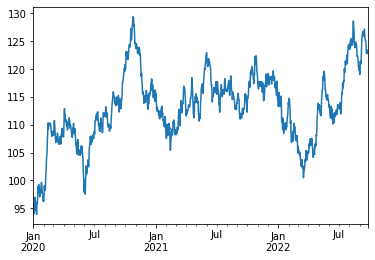

In [5]:
df += df.min() + 100
df.plot();

In [6]:
df = df.to_frame()

In [7]:
df.columns =['price']

In [8]:
window_size = 30 #30 day volatility

In [9]:
df["vol"] = df.pct_change().rolling(5).std()*(365**0.5)

In [10]:
df

,price,vol
2020-01-01,95.787223,NaN
2020-01-02,95.229603,NaN
2020-01-03,93.970919,NaN
2020-01-04,94.293397,NaN
2020-01-05,94.541119,NaN
...,...,...
2022-09-22,122.930390,0.098698
2022-09-23,122.992656,0.106035
2022-09-24,123.433420,0.119683
2022-09-25,122.785299,0.105356


In [11]:
df["volvol"] = df["vol"].pct_change().rolling(5).std()*(365**0.5)

In [12]:
df.head(15)

,price,vol,volvol
2020-01-01,95.787223,NaN,NaN
2020-01-02,95.229603,NaN,NaN
2020-01-03,93.970919,NaN,NaN
2020-01-04,94.293397,NaN,NaN
2020-01-05,94.541119,NaN,NaN
2020-01-06,96.938610,0.276809,NaN
2020-01-07,96.411878,0.275766,NaN
2020-01-08,96.185404,0.231061,NaN
2020-01-09,94.988931,0.274825,NaN
2020-01-10,94.514234,0.279782,NaN


In [13]:
df.mean(axis = 0)

price     113.116496
vol         0.158344
volvol      5.275484
dtype: float64

In [14]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.expanding.html
df["theta"] = df["price"].expanding().var()

In [15]:
df

,price,vol,volvol,theta
2020-01-01,95.787223,NaN,NaN,NaN
2020-01-02,95.229603,NaN,NaN,0.155470
2020-01-03,93.970919,NaN,NaN,0.865698
2020-01-04,94.293397,NaN,NaN,0.700515
2020-01-05,94.541119,NaN,NaN,0.540973
...,...,...,...,...
2022-09-22,122.930390,0.098698,2.966262,42.675694
2022-09-23,122.992656,0.106035,3.061385,42.731469
2022-09-24,123.433420,0.119683,3.317136,42.795879
2022-09-25,122.785299,0.105356,2.450404,42.846955


In [16]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

In [17]:
# https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/

def hurst(ts):
    

    # Create the range of lag values
    lags = range(2, 50)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [18]:
gbm = log(cumsum(randn(100000))+1000)
mr = log(randn(100000)+1000)
tr = log(cumsum(randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
print("Hurst(GBM):   %s" % hurst(gbm))
print("Hurst(MR):    %s" % hurst(mr))
print("Hurst(TR):    %s" % hurst(tr))

Hurst(GBM):   0.5057423150839598
Hurst(MR):    0.0002145342914722208
Hurst(TR):    0.9446655716722471


In [19]:
hurst(df['price'].values)

0.49039818574705485

In [20]:
import matplotlib.pyplot as plt

Hurst(GBM):   0.5057423150839598


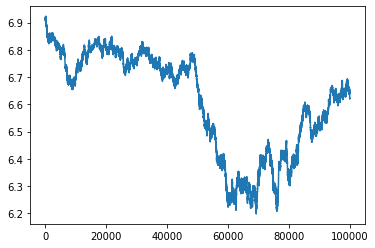

In [21]:
plt.plot(gbm)
print("Hurst(GBM):   %s" % hurst(gbm))

Hurst(MR):    0.0002145342914722208


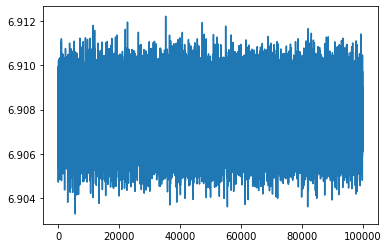

In [22]:
plt.plot(mr)
print("Hurst(MR):    %s" % hurst(mr))

Hurst(TR):    0.9446655716722471


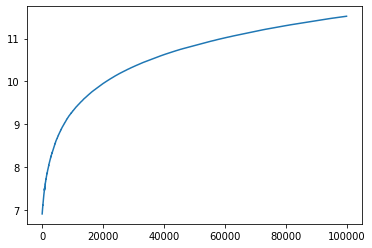

In [23]:
plt.plot(tr)
print("Hurst(TR):    %s" % hurst(tr))

0.49039818574705485

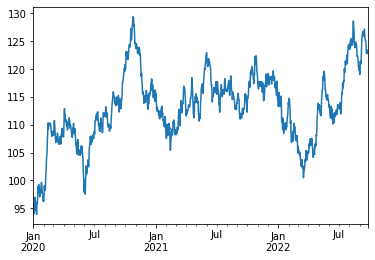

In [24]:
df["price"].plot()
hurst(df["price"].values)

In [25]:
# https://www.investopedia.com/terms/m/meanreversion.asp

In [26]:
df["kappa"] = hurst(df['price'].values)

In [28]:
df["kappa"] = df["price"].pct_change().rolling(200).std()*(365**0.5)

In [31]:
df["kappa"] = hurst(df["price"]rolling.values)

In [27]:
df

,price,vol,volvol,theta,kappa
2020-01-01,95.787223,NaN,NaN,NaN,0.490398
2020-01-02,95.229603,NaN,NaN,0.155470,0.490398
2020-01-03,93.970919,NaN,NaN,0.865698,0.490398
2020-01-04,94.293397,NaN,NaN,0.700515,0.490398
2020-01-05,94.541119,NaN,NaN,0.540973,0.490398
...,...,...,...,...,...
2022-09-22,122.930390,0.098698,2.966262,42.675694,0.490398
2022-09-23,122.992656,0.106035,3.061385,42.731469,0.490398
2022-09-24,123.433420,0.119683,3.317136,42.795879,0.490398
2022-09-25,122.785299,0.105356,2.450404,42.846955,0.490398


In [32]:
df["rho"] = df["price"].expanding().corr(df["vol"])

In [33]:
df

,price,vol,volvol,theta,kappa,rho
2020-01-01,86.412456,NaN,NaN,NaN,0.528203,NaN
2020-01-02,86.675123,NaN,NaN,0.034497,0.528203,NaN
2020-01-03,86.455662,NaN,NaN,0.019837,0.528203,NaN
2020-01-04,85.341399,NaN,NaN,0.357216,0.528203,NaN
2020-01-05,86.418403,NaN,NaN,0.275693,0.528203,NaN
...,...,...,...,...,...,...
2022-09-22,105.879506,0.283302,2.878334,71.594626,0.528203,-0.291035
2022-09-23,107.099444,0.284834,2.623188,71.740366,0.528203,-0.288441
2022-09-24,106.330812,0.185912,3.911777,71.863303,0.528203,-0.288365
2022-09-25,105.658932,0.195454,3.451173,71.967316,0.528203,-0.288116


In [34]:
df["price"]

2020-01-01     86.412456
2020-01-02     86.675123
2020-01-03     86.455662
2020-01-04     85.341399
2020-01-05     86.418403
                 ...    
2022-09-22    105.879506
2022-09-23    107.099444
2022-09-24    106.330812
2022-09-25    105.658932
2022-09-26    104.971165
Freq: D, Name: price, Length: 1000, dtype: float64

In [32]:
### doesn't work past here

In [31]:
df['new_column'] = priceHestonMid(df["price"],df["price"],0.2,0.1,df["vol"],df["kappa"],df["theta"],df["volvol"],df["rho"])

KeyboardInterrupt: 

In [ ]:
def heston(row):
    i = complex(0, 1)
    # current price
    St = row["price"]
    # strike
    K = row["price"]
    # risk free interest rate
    r = 0.2
    # time to maturity
    T = 0.1
    # volatility 
    sigma = row["vol"]
    # kappa = ?
    kappa = row["kappa"]
    # theta = ?
    theta = row["theta"]
    # volatility of volatility
    volvol = row["volvol"]
    # rho = ?
    rho = row["rho"]
    
    c = priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho)
    
    return c

 drift of the stock process
 mean reversion coefficient of the variance process
 long term mean of the variance process
 volatility coefficient of the variance process
 correlation between 
 and 
 i.e.

sigma -  the initial volatility.

theta - the long variance, or long-run average variance of the price; as t tends to infinity, the expected value of νt tends to θ.

rho - the correlation of the two Wiener processes.

kappa -  the rate at which νt reverts to θ.

volvol - the volatility of the volatility, or 'vol of vol', which determines the variance of νt.

In [ ]:
# current price
St = 75
# strike
K = 75
# risk free interest rate
r = 0.2
# time to maturity
T = 0.1
# volatility 
sigma = 0.226550
# kappa = ?
kappa = 0.1
# theta = ?
theta = 1.877432
# volatility of volatility
volvol = 0.3
# rho = ?
rho = -0.570497

In [ ]:
priceHestonMid(St, K, r, T, sigma, kappa, theta, volvol, rho)

In [ ]:
bs_call(St, K, T, r, sigma)